In [1]:
from lasagne.layers import (
    InputLayer, GaussianNoiseLayer, DropoutLayer, DenseLayer,
    get_output, get_all_params, get_all_param_values
)
from lasagne.regularization import regularize_network_params, l1, l2
from lasagne.objectives import binary_crossentropy
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import elu, sigmoid
from collections import OrderedDict
from theano import tensor as T
import theano

from sklearn.datasets import fetch_mldata
import numpy as np
import os


import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans

In [2]:
def load_data(data_location):
    mnist = fetch_mldata('MNIST original', data_home=data_location)

    sampling_vec = np.random.choice(len(mnist.target), len(mnist.target))
    X = mnist.data[sampling_vec]
    
    X = (X / 255.).astype(theano.config.floatX)
    y = mnist.target[sampling_vec]

    trainX, trainy = X[:50000], y[:50000]
    valX, valy = X[50000:60000], y[50000:60000]
    testX, testy = X[60000:], y[60000:]
    
    return trainX, trainy, valX, valy, testX, testy

# from: https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape) == 2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [3]:
data_location = os.path.expanduser('~/mnist_data')
print(data_location)
print()

trainX, trainy, valX, valy, testX, testy = load_data(data_location)

print(trainX.shape)
print(trainy.shape)
print()
print(valX.shape)
print(valy.shape)
print()
print(testX.shape)
print(testy.shape)

/home/c/mnist_data

(50000, 784)
(50000,)

(10000, 784)
(10000,)

(10000, 784)
(10000,)


In [4]:
input_var = T.matrix('input', dtype=theano.config.floatX)
embedding_size = 800
drop_in_prob = 0.25
embedding_drop_prob = 0.5
input_size = 784
sigma = 0.1
l2_reg_coeff = 1e-4
l1_reg_coeff = 5e-5

net = OrderedDict()
net['input'] = InputLayer(
    (None, input_size),
    input_var=input_var
)

net['input_dropout'] = DropoutLayer(
    net['input'],
    p=drop_in_prob
)

net['noise'] = GaussianNoiseLayer(
    net['input_dropout'],
    sigma=sigma
)

net['embedding'] = DenseLayer(
    net['noise'],
    embedding_size,
    nonlinearity=elu
)

net['embedding_dropout'] = DropoutLayer(
    net['embedding'],
    p=embedding_drop_prob
)

net['pred'] = DenseLayer(
    net['embedding'],
    input_size,
    nonlinearity=sigmoid
)

prediction = get_output(net['pred'])
loss = binary_crossentropy(prediction, input_var)

l2_reg = l2_reg_coeff * regularize_network_params(net['pred'], l2)
l1_reg = l1_reg_coeff * regularize_network_params(net['pred'], l1)
loss = loss.mean() + l1_reg + l2_reg

params = get_all_params(net['pred'], trainable=True)
updates = nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

train_function = theano.function(
    [input_var],
    loss,
    updates=updates
)

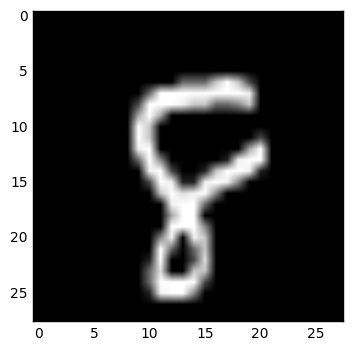

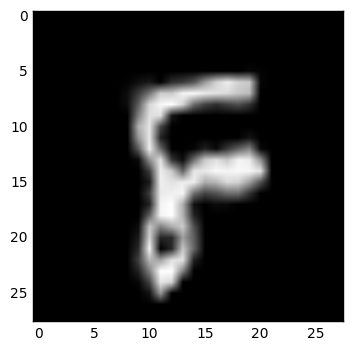

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

img = trainX[1].reshape((28, 28))
img_trans = elastic_transform(img, 8, 1.8)
plt.imshow(img, cmap='Greys_r')
plt.figure()
plt.imshow(img_trans, cmap='Greys_r')

In [138]:
def batch_process(input_batch):
    def process_slice(data_slice):
        img = data_slice.reshape(28, 28)
        distorted = elastic_transform(img, 8, 1.8)
        return distorted.flatten()
    
    return np.apply_along_axis(process_slice, 1, input_batch)

def data_generator(input_data, n_chunks=100):
    chunks = np.array_split(input_data, n_chunks)
    while True:
        for chunk in chunks:
            yield(batch_process(chunk))
            
        yield None

data_gen = data_generator(trainX)
n_epochs = 10
report_n_iter = 20

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.
    report_loss = 0.
    
    for idx, chunk in enumerate(data_gen, 1):
        if chunk is None:
            iters_for_epoch = idx
            break
        
        loss_val = train_function(chunk)
        report_loss += loss_val
        epoch_loss += loss_val
        
        if idx % report_n_iter == 0:
            print(
                'Loss for last {} iters, {:.5f}'.format(
                    report_n_iter, report_loss / report_n_iter
                )
            )
            report_loss = 0.
            
    print(
        'Loss for epoch, {:.5f}'.format(
            epoch_loss / iters_for_epoch
        )
    )

    

Loss for last 20 iters, 0.31987
Loss for last 20 iters, 0.31910
Loss for last 20 iters, 0.31995
Loss for last 20 iters, 0.31859
Loss for last 20 iters, 0.31813
Loss for epoch, 0.31597
Loss for last 20 iters, 0.31892
Loss for last 20 iters, 0.31832
Loss for last 20 iters, 0.31872
Loss for last 20 iters, 0.31783
Loss for last 20 iters, 0.31775
Loss for epoch, 0.31516
Loss for last 20 iters, 0.31789
Loss for last 20 iters, 0.31742
Loss for last 20 iters, 0.31809
Loss for last 20 iters, 0.31734
Loss for last 20 iters, 0.31638
Loss for epoch, 0.31428
Loss for last 20 iters, 0.31729
Loss for last 20 iters, 0.31732
Loss for last 20 iters, 0.31752
Loss for last 20 iters, 0.31685
Loss for last 20 iters, 0.31629
Loss for epoch, 0.31392
Loss for last 20 iters, 0.31683
Loss for last 20 iters, 0.31603
Loss for last 20 iters, 0.31676
Loss for last 20 iters, 0.31603
Loss for last 20 iters, 0.31535
Loss for epoch, 0.31307
Loss for last 20 iters, 0.31600
Loss for last 20 iters, 0.31583
Loss for last 20

In [ ]:
np.savez('model.npz', *get_all_param_values(net['pred']))

In [5]:
with np.load('train_model.npz') as f:
    param_values = [f['arr_{}'.format(i)] for i in range(len(f.files))]

In [6]:
encoding = get_output(net['embedding'], deterministic=True)

encoding_function = theano.function(
    [input_var],
    encoding
)

In [7]:
from sklearn.preprocessing import normalize

encoded = encoding_function(valX)
# encoded = normalize(encoded)
encoded_test = encoding_function(testX)

In [ ]:
max_k = 20

inertias = np.zeros(max_k)
for k_val in range(1, max_k + 1):
    kmeans = MiniBatchKMeans(n_clusters=k_val).fit(encoded)
    inertias[k_val - 1] = kmeans.inertia_

plt.plot(list(range(1, max_k + 1)), inertias)

In [ ]:
for quant_val in np.linspace(10, 200, 20):
    kmeans = MiniBatchKMeans(n_clusters=int(quant_val)).fit(encoded)
    centers = kmeans.cluster_centers_

    distance_space = kmeans.transform(encoded)

    from sklearn.svm import SVC
    clf = SVC()
    clf.fit(distance_space, valy)

    # encoded_test = normalize(encoded_test)
    distance_test = kmeans.transform(encoded_test)
    test_pred = clf.predict(distance_test)

    acc = (np.sum((test_pred == testy)) * 100) / len(testy)
    print('Test set accuracy quantised to {}, {:.2f}%'.format(quant_val, acc))

Test set accuracy quantised to 10.0, 85.93%
Test set accuracy quantised to 20.0, 90.58%
Test set accuracy quantised to 30.0, 92.09%


In [26]:
np.linspace(10, 200, 20)

array([  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
        100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
        190.,  200.])

In [24]:
800/20

40.0